In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

intial data

1000 colums and 10 metrics

In [ ]:
df = pd.read_csv('metrics.csv')
df.head()
# print(df.info())

,timestamp,cpu_usage,memory_usage,disk_io,network_in,network_out,db_queries,db_latency,app_errors,response_time,active_users
0,2025-01-01 00:00:00,55.052082,35.836442,24.862598,19.796225,22.052899,119.918888,6.942040,2.424845,119.682105,441.122469
1,2025-01-01 00:05:00,42.994891,42.544408,28.802750,28.976530,10.959110,48.764157,4.300685,1.481822,133.844532,385.939515
2,2025-01-01 00:10:00,50.756957,38.272199,22.114400,19.956845,19.768088,140.011782,4.799572,2.407843,265.416551,547.382904
3,2025-01-01 00:15:00,53.165998,39.243855,23.676543,27.456220,16.797400,84.131386,7.769680,1.713054,188.618634,673.131839
4,2025-01-01 00:20:00,48.200113,33.354073,24.526947,22.425039,5.285591,86.012965,6.188546,2.663550,179.486447,384.999948


- getting timevalue in mins


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['hour'] = df['timestamp'].dt.hour
df['minutes'] = df['timestamp'].dt.minute
df['timevalue'] = df['hour']*60 + df['minutes']

df.head()

,timestamp,cpu_usage,memory_usage,disk_io,network_in,network_out,db_queries,db_latency,app_errors,response_time,active_users,hour,minutes,timevalue
0,2025-01-01 00:00:00,55.052082,35.836442,24.862598,19.796225,22.052899,119.918888,6.942040,2.424845,119.682105,441.122469,0,0,0
1,2025-01-01 00:05:00,42.994891,42.544408,28.802750,28.976530,10.959110,48.764157,4.300685,1.481822,133.844532,385.939515,0,5,5
2,2025-01-01 00:10:00,50.756957,38.272199,22.114400,19.956845,19.768088,140.011782,4.799572,2.407843,265.416551,547.382904,0,10,10
3,2025-01-01 00:15:00,53.165998,39.243855,23.676543,27.456220,16.797400,84.131386,7.769680,1.713054,188.618634,673.131839,0,15,15
4,2025-01-01 00:20:00,48.200113,33.354073,24.526947,22.425039,5.285591,86.012965,6.188546,2.663550,179.486447,384.999948,0,20,20


- using minmax scaler to scale all metric values including timevalue

In [ ]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = [
    'cpu_usage', 'memory_usage', 'disk_io', 'network_in',
    'network_out', 'db_queries', 'db_latency', 'app_errors',
    'response_time', 'active_users','timevalue'
]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)
scaled_df.head()

,cpu_usage,memory_usage,disk_io,network_in,network_out,db_queries,db_latency,app_errors,response_time,active_users,timevalue
0,0.601600,0.352439,0.530394,0.507043,0.561662,0.646328,0.665612,0.573473,0.239223,0.425089,0.000000
1,0.327384,0.562658,0.705954,0.773767,0.270648,0.237219,0.467657,0.422087,0.284981,0.334260,0.003484
2,0.503916,0.428772,0.407943,0.511710,0.501726,0.761853,0.505046,0.570744,0.710087,0.599990,0.006969
3,0.558705,0.459223,0.477547,0.729596,0.423799,0.440565,0.727639,0.459207,0.461955,0.806968,0.010453
4,0.445766,0.274645,0.515438,0.583420,0.121820,0.451383,0.609142,0.611793,0.432449,0.332714,0.013937


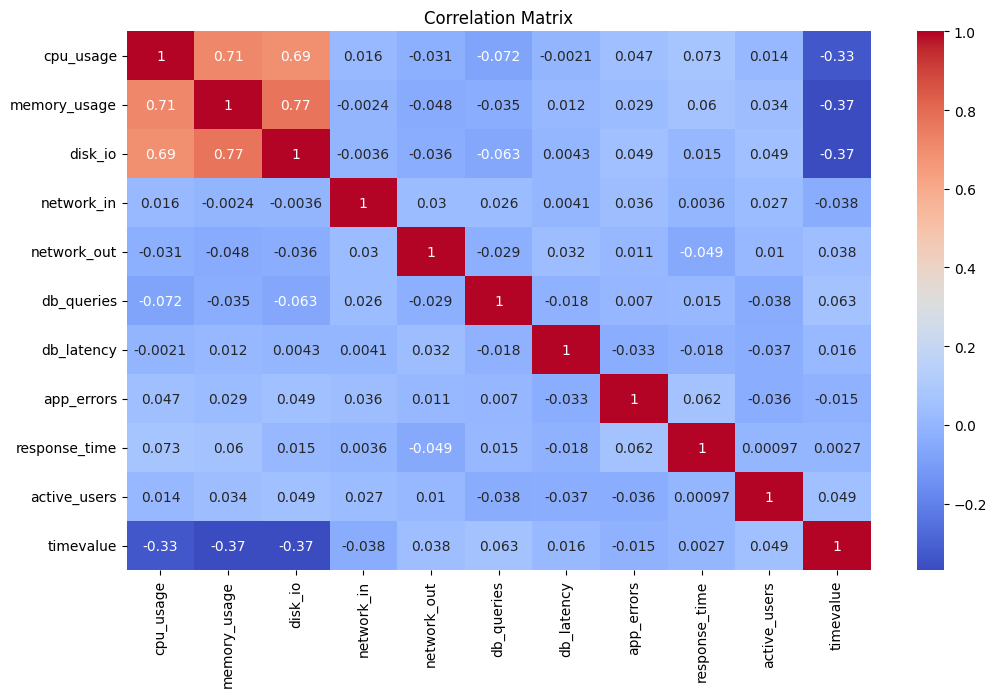

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix from the scaled DataFrame
corr_matrix = scaled_df.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

- cosine similarity on scaled df

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_matrix = cosine_similarity(scaled_df.T)
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=numerical_cols, columns=numerical_cols)

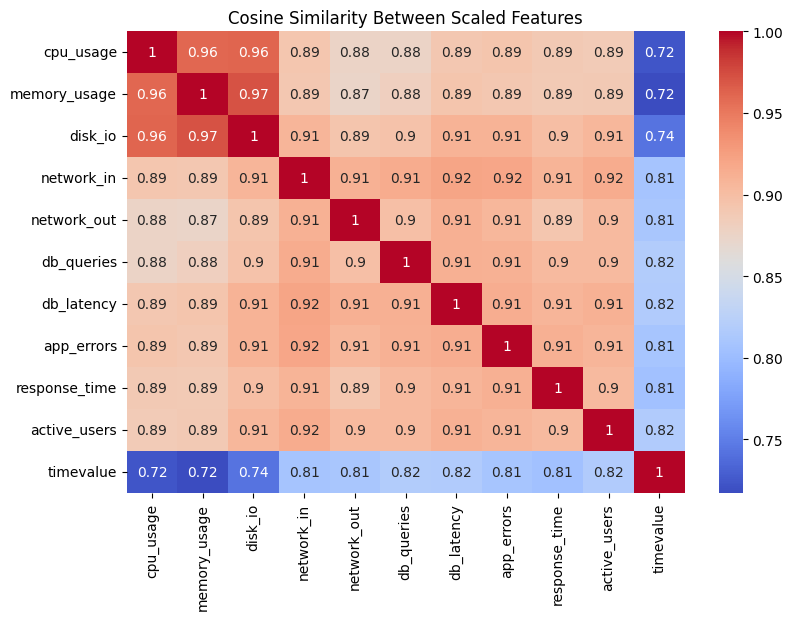

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.heatmap(cos_sim_df, annot=True, cmap="coolwarm")
plt.title("Cosine Similarity Between Scaled Features")
plt.show()

## splitting data for model

In [ ]:
time_scaled =scaled_df['timevalue'].values.reshape(-1,1) # the shape of this will be [1000,1]
metrics_scaled = scaled_df.drop(columns=['timevalue']).values
metrics_scaled.shape

(1000, 10)

so for every time `t` we predict the metrics at `t+1`

In [ ]:
X = time_scaled[:-1]
print(X.shape)
Y = metrics_scaled[1:]
print(Y.shape)

(999, 1)
(999, 10)


In [ ]:
X_tensor = torch.tensor(X, dtype= torch.float32)
Y_tensor = torch.tensor(Y, dtype = torch.float32)
print(X_tensor.shape)
print(Y_tensor.shape)

torch.Size([999, 1])
torch.Size([999, 10])


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size = 0.2, random_state = 42)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = 32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32)

## model classes

In [ ]:
import torch
from torch import nn
import numpy as np
import math

def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        #print(w.shape, t1.shape, b.shape)
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], -1)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.cos

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

if __name__ == "__main__":
    sineact = SineActivation(1, 64)
    cosact = CosineActivation(1, 64)

    print(sineact(torch.Tensor([[7]])).shape)
    print(cosact(torch.Tensor([[7]])).shape)


torch.Size([1, 64])
torch.Size([1, 64])


In [ ]:
class Model(nn.Module):
    def __init__(self, activation, hidden_dim,output_dim = 10):
        super(Model, self).__init__()
        if activation == "sin":
            self.l1 = SineActivation(1, hidden_dim)
        elif activation == "cos":
            self.l1 = CosineActivation(1, hidden_dim)

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64,output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.l1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        # print("Input shape:", x.shape)
        # #x = x.unsqueeze(1)
        # x = self.l1(x)
        # print("After l1:", x.shape)
        # x = self.relu(self.fc1(x))
        # print("After fc1 + relu:", x.shape)
        # x = self.fc2(x)
        # print("After fc2:", x.shape)
        # return x

In [ ]:
model = Model(activation = 'sin', hidden_dim = 64)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
loss_fn = nn.MSELoss()

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for batch_x , batch_y in train_dataloader:
    optimizer.zero_grad()
    preds = model(batch_x)
    loss = loss_fn(preds,batch_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
      preds = model(batch_x)
      loss = loss_fn(preds,batch_y)
      test_loss += loss.item()

  print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_dataloader)}, Test Loss: {test_loss/len(test_dataloader)}")



Epoch 1, Train Loss: 0.3463637602329254, Test Loss: 0.3352686251912798
Epoch 2, Train Loss: 0.3364423906803131, Test Loss: 0.3257289912019457
Epoch 3, Train Loss: 0.32687036991119384, Test Loss: 0.3165278307029179
Epoch 4, Train Loss: 0.31764517068862913, Test Loss: 0.3076571226119995
Epoch 5, Train Loss: 0.3087375771999359, Test Loss: 0.29909491539001465
Epoch 6, Train Loss: 0.300116765499115, Test Loss: 0.2908091757978712
Epoch 7, Train Loss: 0.2917474675178528, Test Loss: 0.28273617369788034
Epoch 8, Train Loss: 0.2835726082324982, Test Loss: 0.27480694225856234
Epoch 9, Train Loss: 0.2755482280254364, Test Loss: 0.26705792972019743
Epoch 10, Train Loss: 0.2677287805080414, Test Loss: 0.25952433901173727
Epoch 11, Train Loss: 0.2601143217086792, Test Loss: 0.2521855703422001
Epoch 12, Train Loss: 0.2526895833015442, Test Loss: 0.24502969213894435
Epoch 13, Train Loss: 0.2454361653327942, Test Loss: 0.23803945524351938
Epoch 14, Train Loss: 0.23838645935058594, Test Loss: 0.231327695

In [ ]:
model.eval()
with torch.no_grad():
  time_embeddings = model.l1(torch.FloatTensor(time_scaled))

time_embeddings.shape

torch.Size([1000, 64])

In [ ]:
correlations = []
time_embeddings_np = time_embeddings.detach().cpu().numpy()
for col in numerical_cols:
    if col != 'timevalue':
      metric_series = scaled_df[col].values
      corr_with_each_dim = [np.corrcoef(metric_series, time_embeddings_np[:, i])[0, 1] for i in range(64)]
      correlations.append(np.nanmean(np.abs(corr_with_each_dim)))

metric_corr = pd.Series(correlations, index=[c for c in numerical_cols if c != 'timevalue']).sort_values(ascending=False)
print(metric_corr)


memory_usage     0.383590
disk_io          0.381605
cpu_usage        0.347854
db_queries       0.060629
active_users     0.046569
network_in       0.036848
network_out      0.035411
db_latency       0.016207
app_errors       0.016022
response_time    0.008989
dtype: float64


In [ ]:
correlations1 = []
for col in numerical_cols:
    if col != 'timevalue':
        metric_series = scaled_df[col].values
        corr = np.corrcoef(metric_series, scaled_df['timevalue'].values)[0, 1]
        correlations1.append(np.nanmean(np.abs(corr)))

metric_corr = pd.Series(correlations1, index=[c for c in numerical_cols if c != 'timevalue']).sort_values(ascending=False)
print(metric_corr)

memory_usage     0.369901
disk_io          0.367245
cpu_usage        0.333447
db_queries       0.062836
active_users     0.049054
network_out      0.038194
network_in       0.038146
db_latency       0.016305
app_errors       0.014699
response_time    0.002685
dtype: float64
